In [1]:
import os
from pathlib import Path
import anndata as an
import numpy as np
import pandas as pd
# from biokowloon import sc as bio_sc
import deside
import matplotlib.pyplot as plt
import seaborn as sns
from deside.utility import check_dir, set_fig_style, print_df, get_ccc, non_log2log_cpm, non_log2cpm
from deside.decon_cf import DeSide
from deside.utility.read_file import read_gene_set, ReadH5AD

2024-06-16 18:08:51.926084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Using the ascites dataset from Scaden - convert to log2(TPM + 1) for DeSide training

In [10]:
ascite_obj = ReadH5AD('../datasets/from_scaden/ascites_training.h5ad')
ascite_exp = ascite_obj.get_df()
ascite_exp.head(2)

index,1-Dec,1-Mar,10-Mar,10-Sep,11-Sep,12-Sep,14-Sep,2-Mar,2-Sep,3-Mar,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
index,,,,,,,,,,,,,,,,,,,,,
0-0,226.393005,149.542007,24.858000,87.435997,508.570007,14.522,129.304001,29.618999,2740.294922,39.963001,...,54.500000,103.848999,152.139008,51.776001,114.667000,160.009995,389.252014,3271.154053,1193.588989,385.463013
1-0,560.362000,258.967987,45.745998,403.757996,603.606018,14.692,208.983994,38.424999,4474.164062,183.541000,...,67.724998,231.317993,323.049011,54.096001,225.240997,190.175995,684.737000,6369.308105,1584.462036,601.476990


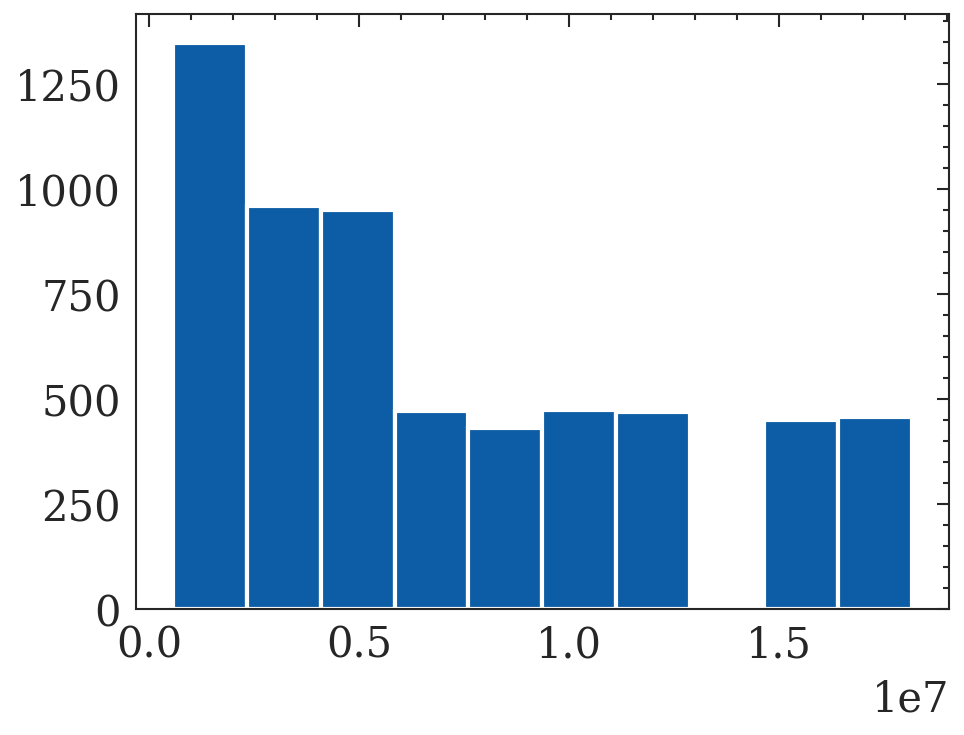

In [12]:
plt.hist(ascite_exp.sum(axis=1), bins=10);

In [4]:
ascite_ds.obs.head(2)

,CD8Tcells,Monocytes,Carcinoma,NK,DC,CD4Tcells,Fibroblast,ds,batch
index,,,,,,,,,
0-0,0.087386,0.108544,0.089107,0.368585,0.243547,0.099272,0.003560,ascites,0
1-0,0.016470,0.189047,0.149305,0.186448,0.119609,0.160128,0.178993,ascites,0


In [14]:
ascite_cell_prop = ascite_ds.obs.rename(columns={'CD8Tcells': 'CD8 T', 'Monocytes': 'Monocytes', 'Carcinoma': 'Cancer Cells', 
                                                 'CD4Tcells': 'CD4 T', 'Fibroblast': 'Fibroblasts'})
ascite_cell_prop = ascite_cell_prop.iloc[:, range(0, 7)].copy()
ascite_cell_prop.head(2)

,CD8 T,Monocytes,Cancer Cells,NK,DC,CD4 T,Fibroblasts
index,,,,,,,
0-0,0.087386,0.108544,0.089107,0.368585,0.243547,0.099272,0.003560
1-0,0.016470,0.189047,0.149305,0.186448,0.119609,0.160128,0.178993


In [15]:
ascite_exp.shape

(6006, 18863)

In [17]:
ascite_exp = non_log2log_cpm(ascite_exp, transpose=False)
ascite_exp.head(2)

index,1-Dec,1-Mar,10-Mar,10-Sep,11-Sep,12-Sep,14-Sep,2-Mar,2-Sep,3-Mar,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
index,,,,,,,,,,,,,,,,,,,,,
0-0,4.323,3.761,1.627,3.061,5.450,1.150,3.568,1.802,7.853,2.123,...,2.480,3.281,3.784,2.419,3.41,3.852,5.075,8.107,6.662,5.061
1-0,5.010,3.948,1.827,4.555,5.114,0.863,3.661,1.651,7.968,3.489,...,2.255,3.796,4.248,2.005,3.76,3.536,5.291,8.475,6.480,5.109


In [20]:
np.all(ascite_exp.index == ascite_cell_prop.index)

True

In [19]:
ascite_h5ad = an.AnnData(X=ascite_exp, obs=ascite_cell_prop, dtype=np.float32)
ascite_h5ad.write('../datasets/from_scaden/ascite_scaden_log2cpm1p.h5ad', compression=True)

In [21]:
ascite_cell_prop.columns.to_list()

['CD8 T', 'Monocytes', 'Cancer Cells', 'NK', 'DC', 'CD4 T', 'Fibroblasts']

### Using the luad_kim_05 simulated by Scaden
- generated by Scaden (scaden simulation) using the scRNA-seq dataset, luad_kim_05_gse131907

In [3]:
luad_obj = ReadH5AD('./R2Q6/scaden/scRNAseq_ds_read_counts/luad_kim_05_gse131907/data.h5ad')
luad_exp = luad_obj.get_df()
luad_exp.head(2)

,A1BG,A2M,A2ML1,A4GALT,AAAS,AACS,AADAC,AADAT,AAED1,AAGAB,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,60.896000,1203.141968,0.0,46.763,19.180000,9.636,2.285,1.935,69.568001,21.131001,...,14.512,15.781,8.803,3.507,10.799,0.000,39.993000,116.617996,26.600000,34.705002
1,62.255001,1636.624023,0.0,40.702,25.811001,7.575,2.070,2.194,69.723000,22.417000,...,5.687,8.230,4.451,7.735,6.812,0.728,32.325001,138.304993,34.126999,21.325001


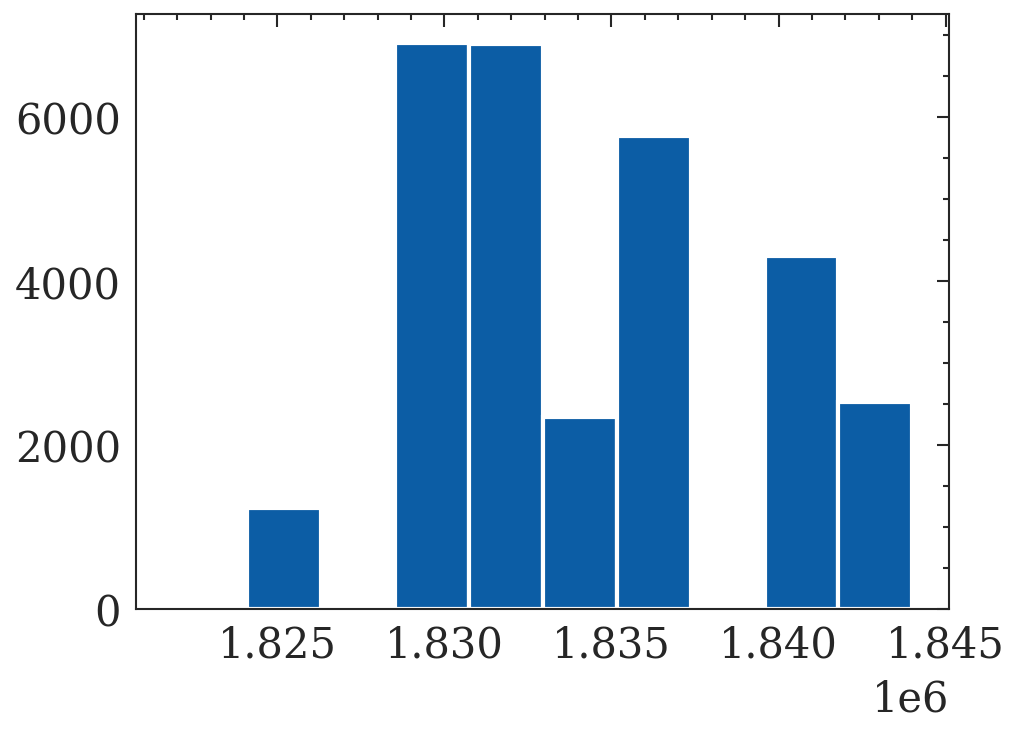

In [4]:
plt.hist(luad_exp.sum(axis=1), bins=10);

In [6]:
luad_h5ad = luad_obj.get_h5ad()
luad_h5ad.obs.head(2)

,T Cells,Endothelial Cells,B Cells,Mast Cells,Myeloid cells,Cancer Cells,Fibroblasts,ds
0,0.127568,0.242936,0.116533,0.041806,0.186543,0.143588,0.141027,
1,0.308700,0.087859,0.072287,0.070999,0.035817,0.086830,0.337507,


In [7]:
# cell_prop = luad_h5ad.obs.rename(columns={'CD8Tcells': 'CD8 T', 'Monocytes': 'Monocytes', 'Carcinoma': 'Cancer Cells', 
                                                 # 'CD4Tcells': 'CD4 T', 'Fibroblast': 'Fibroblasts'})
cell_prop = luad_h5ad.obs.iloc[:, range(0, 7)].copy()
cell_prop.head(2)

,T Cells,Endothelial Cells,B Cells,Mast Cells,Myeloid cells,Cancer Cells,Fibroblasts
0,0.127568,0.242936,0.116533,0.041806,0.186543,0.143588,0.141027
1,0.308700,0.087859,0.072287,0.070999,0.035817,0.086830,0.337507


In [8]:
cell_prop.shape

(30000, 7)

In [9]:
luad_exp = non_log2log_cpm(luad_exp, transpose=False)
luad_exp.head(2)

,A1BG,A2M,A2ML1,A4GALT,AAAS,AACS,AADAC,AADAT,AAED1,AAGAB,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,5.100,9.364,0.0,4.731,3.522,2.648,1.169,1.041,5.287,3.650,...,3.159,3.267,2.539,1.545,2.787,0.000,4.515,6.017,3.958,4.320
1,5.131,9.807,0.0,4.539,3.917,2.362,1.092,1.137,5.290,3.728,...,2.039,2.459,1.780,2.386,2.240,0.483,4.223,6.259,4.297,3.662


In [10]:
np.all(luad_exp.index == cell_prop.index)

True

In [12]:
new_h5ad = an.AnnData(X=luad_exp, obs=cell_prop, dtype=np.float32)
# new_h5ad.write('../datasets/from_scaden/simu_bulk_luad_kim_05_by_scaden_log2cpm1p.h5ad', compression=True)

### Using the prad_cheng_08 simulated by Scaden
- generated by Scaden (scaden simulation) using the scRNA-seq dataset, prad_cheng_08

In [2]:
prad_obj = ReadH5AD('./R2Q6/scaden/scRNAseq_ds_read_counts/prad_cheng_08/data.h5ad')
prad_exp = prad_obj.get_df()
prad_exp.head(2)

,A1BG,A2M,A2ML1,A4GALT,AAAS,AACS,AADAT,AAED1,AAGAB,AAK1,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,70.029999,1376.089966,0.0,58.451000,33.688000,29.184000,10.543000,108.581001,31.263,269.173004,...,10.742,8.609,3.640,23.122,20.934000,0.299,47.971001,119.839996,38.921001,59.084999
1,91.583000,662.070007,0.0,22.146999,35.060001,23.728001,17.702999,85.816002,27.774,457.829010,...,14.824,12.218,5.259,7.678,16.117001,2.910,41.268002,136.270996,56.964001,58.813000


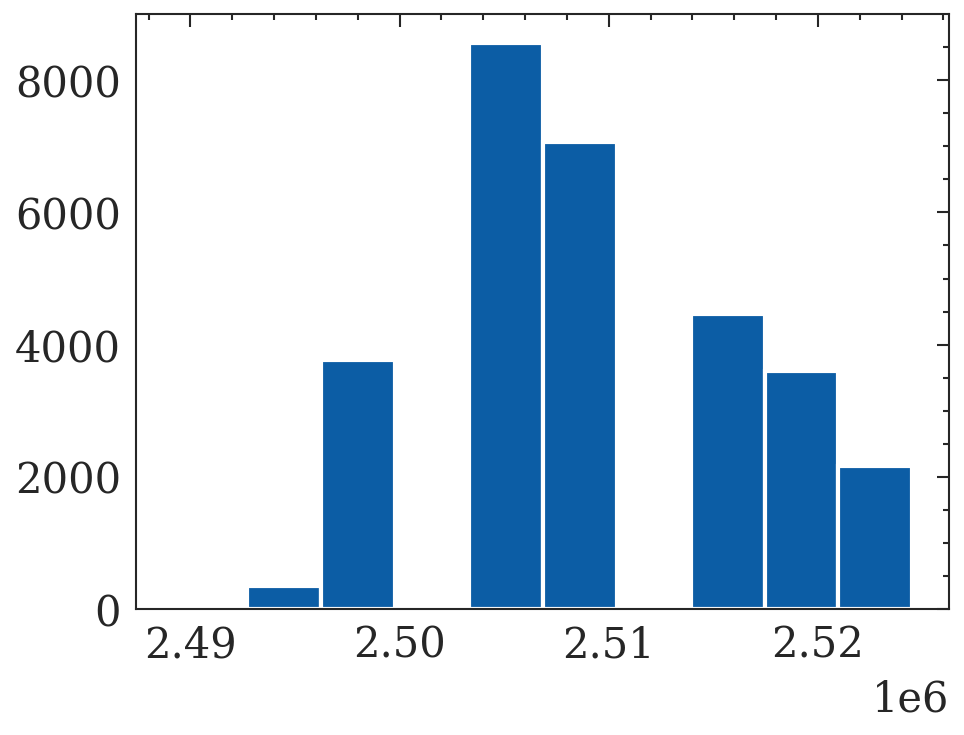

In [3]:
plt.hist(prad_exp.sum(axis=1), bins=10);

In [4]:
prad_h5ad = prad_obj.get_h5ad()
prad_h5ad.obs.head(2)

,Epithelial,B_cell,Macrophage,Malignant,Fibroblast,Mast,T_cell,Endothelial,ds
0,0.062103,0.092807,0.069014,0.178363,0.226232,0.021895,0.094351,0.255235,
1,0.040870,0.080371,0.242177,0.130977,0.042645,0.159820,0.179383,0.123757,


In [6]:
prad_h5ad.obs.rename(columns={'CD8Tcells': 'CD8 T', 'Monocytes': 'Monocytes', 'Malignant': 'Cancer Cells', 
                                          'CD4Tcells': 'CD4 T', 'Fibroblast': 'Fibroblasts',
                                          'Epithelial': 'Epithelial Cells',
                                          'B_cell': 'B Cells', 
                                          'Macrophage': 'Macrophages',
                                          'Mast': 'Mast Cells',
                                          'T_cell': 'T Cells',
                                          'Endothelial': 'Endothelial Cells',
                                         }, inplace=True)
cell_prop = prad_h5ad.obs.iloc[:, range(0, 8)].copy()
cell_prop.head(2)

,Epithelial Cells,B Cells,Macrophages,Cancer Cells,Fibroblasts,Mast Cells,T Cells,Endothelial Cells
0,0.062103,0.092807,0.069014,0.178363,0.226232,0.021895,0.094351,0.255235
1,0.040870,0.080371,0.242177,0.130977,0.042645,0.159820,0.179383,0.123757


In [7]:
cell_prop.columns.to_list()

['Epithelial Cells',
 'B Cells',
 'Macrophages',
 'Cancer Cells',
 'Fibroblasts',
 'Mast Cells',
 'T Cells',
 'Endothelial Cells']

In [8]:
cell_prop.shape

(30000, 8)

In [9]:
prad_exp = non_log2log_cpm(prad_exp, transpose=False)
prad_exp.head(2)

,A1BG,A2M,A2ML1,A4GALT,AAAS,AACS,AADAT,AAED1,AAGAB,AAK1,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,4.853,9.102,0.0,4.602,3.850,3.659,2.379,5.468,3.750,6.758,...,2.401,2.148,1.293,3.353,3.224,0.162,4.330,5.608,4.045,4.617
1,5.232,8.052,0.0,3.299,3.907,3.389,3.012,5.140,3.596,7.522,...,2.791,2.556,1.632,2.024,2.894,1.112,4.128,5.792,4.570,4.614


In [10]:
np.all(prad_exp.index == cell_prop.index)

True

In [11]:
new_h5ad = an.AnnData(X=prad_exp, obs=cell_prop, dtype=np.float32)
# new_h5ad.write('../datasets/from_scaden/simu_bulk_prad_cheng_08_by_scaden_log2cpm1p.h5ad', compression=True)

In [13]:
prad_h5ad = an.read_h5ad('../datasets/from_scaden/simu_bulk_prad_cheng_08_by_scaden_log2cpm1p.h5ad')
prad_h5ad

AnnData object with n_obs × n_vars = 30000 × 16788
    obs: 'Epithelial Cells', 'B Cells', 'Macrophages', 'Cancer Cells', 'Fibroblasts', 'Mast Cells', 'T Cells', 'Endothelial Cells'

### Using the gbm_abdelfattah_12 simulated by Scaden
- generated by Scaden (scaden simulation) using the scRNA-seq dataset, gbm_abdelfattah_12

In [2]:
gbm_obj = ReadH5AD('./R2Q6/scaden/scRNAseq_ds_read_counts/gbm_abdelfattah_12/data.h5ad')
gbm_exp = gbm_obj.get_df()
gbm_exp.head(2)

,A1BG,A2M,A2ML1,A4GALT,AAAS,AACS,AADAT,AAED1,AAGAB,AAK1,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
0,197.501007,1228.782959,0.000,30.559,44.070999,28.149,5.119,10.352,47.630001,535.833984,...,42.028999,18.302000,30.171000,2.991,17.280001,35.782001,0.000,128.735001,252.386002,93.415001
1,168.235992,1230.363037,2.189,13.389,23.684000,15.522,1.759,17.909,61.321999,705.987976,...,20.636000,38.869999,33.692001,3.741,12.896000,47.209999,2.119,107.404999,303.707001,134.460999


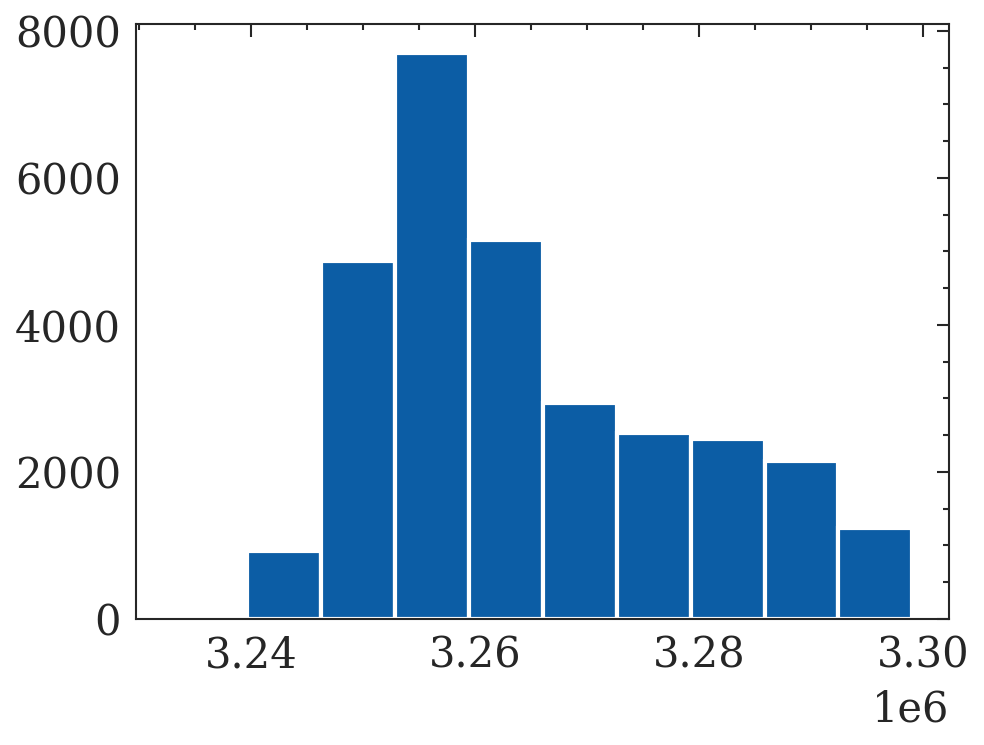

In [3]:
plt.hist(gbm_exp.sum(axis=1), bins=10);

In [4]:
gbm_h5ad = gbm_obj.get_h5ad()
gbm_h5ad.obs.head(2)

,Mast Cells,Neutrophils,NK,CD4 T,Cancer Cells,Monocytes,B Cells,Endothelial Cells,Macrophages,Double-neg-like T,Fibroblasts,CD8 T,DC,ds
0,0.136436,0.045150,0.134312,0.047599,0.040585,0.037903,0.116797,0.083924,0.014582,0.054499,0.085408,0.070056,0.132747,
1,0.018895,0.012698,0.135948,0.077079,0.091967,0.081793,0.032135,0.070739,0.137209,0.078677,0.027881,0.139274,0.095706,


In [5]:
# cell_prop = prad_h5ad.obs.rename(columns={'CD8Tcells': 'CD8 T', 'Monocytes': 'Monocytes', 'Malignant': 'Cancer Cells', 
#                                           'CD4Tcells': 'CD4 T', 'Fibroblast': 'Fibroblasts',
#                                           'Epithelial': 'Epithelial Cells',
#                                           'B_cell': 'B Cells', 
#                                           'Macrophage': 'Macrophages',
#                                           'Mast': 'Mast Cells',
#                                           'T_cell': 'T Cells',
#                                           'Endothelial': 'Endothelial Cells',
#                                          })
cell_prop = gbm_h5ad.obs.iloc[:, range(0, 13)].copy()
cell_prop.head(2)

,Mast Cells,Neutrophils,NK,CD4 T,Cancer Cells,Monocytes,B Cells,Endothelial Cells,Macrophages,Double-neg-like T,Fibroblasts,CD8 T,DC
0,0.136436,0.045150,0.134312,0.047599,0.040585,0.037903,0.116797,0.083924,0.014582,0.054499,0.085408,0.070056,0.132747
1,0.018895,0.012698,0.135948,0.077079,0.091967,0.081793,0.032135,0.070739,0.137209,0.078677,0.027881,0.139274,0.095706


In [6]:
cell_prop.shape

(30000, 13)

In [7]:
gbm_exp = non_log2log_cpm(gbm_exp, transpose=False)
gbm_exp.head(2)

,A1BG,A2M,A2ML1,A4GALT,AAAS,AACS,AADAT,AAED1,AAGAB,AAK1,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
0,5.945,8.562,0.000,3.375,3.860,3.268,1.362,2.062,3.965,7.370,...,3.796,2.726,3.358,0.939,2.656,3.582,0.000,5.340,6.293,4.890
1,5.723,8.570,0.744,2.357,3.052,2.531,0.625,2.704,4.314,7.771,...,2.879,3.698,3.508,1.106,2.314,3.958,0.725,5.091,6.563,5.407


In [8]:
np.all(gbm_exp.index == cell_prop.index)

True

In [9]:
new_h5ad = an.AnnData(X=gbm_exp, obs=cell_prop, dtype=np.float32)
# new_h5ad.write('../datasets/from_scaden/simu_bulk_gbm_abdelfattah_12_by_scaden_log2cpm1p.h5ad', compression=True)

### Using the hnscc_Kurten2021_3CA simulated by Scaden
- generated by Scaden (scaden simulation) using the scRNA-seq dataset, hnscc_Kurten2021_3CA

In [14]:
hnscc_obj = ReadH5AD('./R2Q6/scaden/scRNAseq_ds_read_counts/HNSCC_Kürten2021_3CA/data.h5ad')
hnscc_exp = hnscc_obj.get_df()
hnscc_exp.head(2)

,A1BG,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL2,AADAT,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
0,87.287003,285.994995,2.084,54.001999,0.0,34.716999,7.743,0.382,0.0,1.909,...,9.137,25.756001,24.820999,2.569,3.054,7.807,0.000,19.514,136.953003,31.240999
1,113.042000,81.959000,4.077,60.985001,0.0,32.439999,18.448,0.000,0.0,1.325,...,7.157,23.702999,22.815001,2.827,2.500,9.222,0.585,12.461,147.067993,15.905000


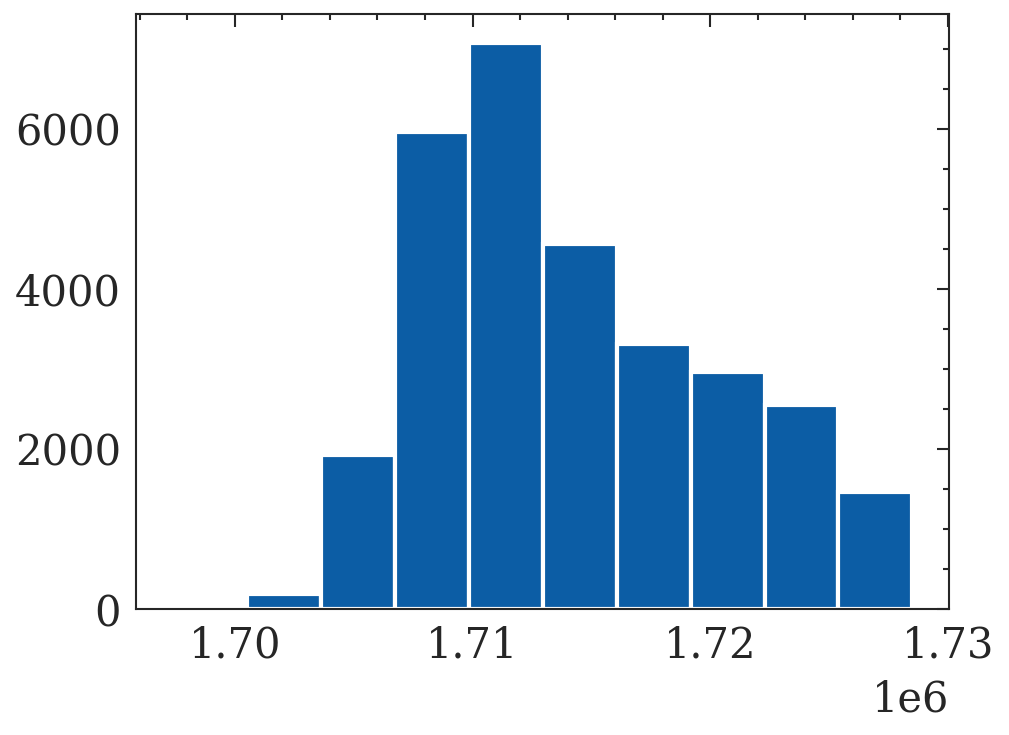

In [15]:
plt.hist(hnscc_exp.sum(axis=1), bins=10);

In [16]:
hnscc_exp.max()

A1BG       279.083008
A2M       1902.368042
A2ML1       80.022003
A4GALT     216.643997
A4GNT        3.598000
             ...     
ZXDC        33.787998
ZYG11A      10.717000
ZYG11B      49.172001
ZYX        341.714996
ZZEF1       54.771000
Length: 16634, dtype: float32

In [17]:
hnscc_h5ad = hnscc_obj.get_h5ad()
hnscc_h5ad.obs.head(2)

,Endothelial,Fibroblast,Dendritic,B_cell,Lymphovascular,Malignant,T_cell,Macrophage,Plasma,Epithelial,Mast,ds
0,0.116415,0.117055,0.095127,0.104020,0.159803,0.041415,0.072157,0.036497,0.064289,0.031508,0.161714,
1,0.010050,0.127655,0.020965,0.000291,0.065787,0.061113,0.044587,0.236316,0.208315,0.154747,0.070175,


In [27]:
cell_prop = hnscc_h5ad.obs.rename(columns={'CD8Tcells': 'CD8 T', 'Monocytes': 'Monocytes', 'Malignant': 'Cancer Cells', 
                                          'CD4Tcells': 'CD4 T', 'Fibroblast': 'Fibroblasts',
                                          'Epithelial': 'Epithelial Cells',
                                          'B_cell': 'B Cells', 
                                          'Macrophage': 'Macrophages',
                                          'Mast': 'Mast Cells',
                                          'T_cell': 'T Cells',
                                           'Dendritic': 'DC',
                                          'Endothelial': 'Endothelial Cells',
                                         }).copy()
cell_prop = cell_prop.iloc[:, range(0, 11)].copy()
cell_prop.head(2)

,Endothelial Cells,Fibroblasts,DC,B Cells,Lymphovascular,Cancer Cells,T Cells,Macrophages,Plasma,Epithelial Cells,Mast Cells
0,0.116415,0.117055,0.095127,0.104020,0.159803,0.041415,0.072157,0.036497,0.064289,0.031508,0.161714
1,0.010050,0.127655,0.020965,0.000291,0.065787,0.061113,0.044587,0.236316,0.208315,0.154747,0.070175


In [28]:
cell_prop.columns.to_list()

['Endothelial Cells',
 'Fibroblasts',
 'DC',
 'B Cells',
 'Lymphovascular',
 'Cancer Cells',
 'T Cells',
 'Macrophages',
 'Plasma',
 'Epithelial Cells',
 'Mast Cells']

In [29]:
cell_prop.shape

(30000, 11)

In [31]:
cell_prop.sum(axis=1)

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
29995    1.0
29996    1.0
29997    1.0
29998    1.0
29999    1.0
Length: 30000, dtype: float64

In [20]:
hnscc_exp = non_log2log_cpm(hnscc_exp, transpose=False)
hnscc_exp.head(2)

,A1BG,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL2,AADAT,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
0,5.701,7.393,1.149,5.025,0.0,4.412,2.466,0.291,0.0,1.081,...,2.664,4.005,3.955,1.323,1.478,2.476,0.000,3.633,6.340,4.267
1,6.065,5.609,1.756,5.192,0.0,4.316,3.556,0.000,0.0,0.826,...,2.371,3.890,3.839,1.405,1.297,2.673,0.423,3.047,6.439,3.361


In [30]:
np.all(hnscc_exp.index == cell_prop.index)

True

In [32]:
new_h5ad = an.AnnData(X=hnscc_exp, obs=cell_prop, dtype=np.float32)
# new_h5ad.write('../datasets/from_scaden/simu_bulk_hnscc_Kurten2021_3CA_by_scaden_log2cpm1p.h5ad', compression=True)

### Using the Geistlinger2020_Ovarian_3CA simulated by Scaden
- generated by Scaden (scaden simulation) using the scRNA-seq dataset, Geistlinger2020_Ovarian_3CA

In [2]:
ov2_obj = ReadH5AD('./R2Q6/scaden/scRNAseq_ds_read_counts/Geistlinger2020_Ovarian_3CA/data.h5ad')
ov2_exp = ov2_obj.get_df()
ov2_exp.head(2)

,A1BG,A2M,A2ML1,A4GALT,AAAS,AACS,AADAC,AADACL2,AADAT,AAED1,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
0,53.710999,289.881012,0.0,17.598,21.407,11.188,2.285,0.2,1.749,41.137001,...,6.403,17.587000,47.334999,6.199,3.221,2.090,0.170,17.764999,102.787003,9.074
1,42.354000,201.341003,0.0,10.977,17.635,11.121,3.442,0.0,1.145,29.417000,...,4.322,19.120001,52.827000,2.264,4.078,5.298,0.142,15.666000,71.720001,12.384


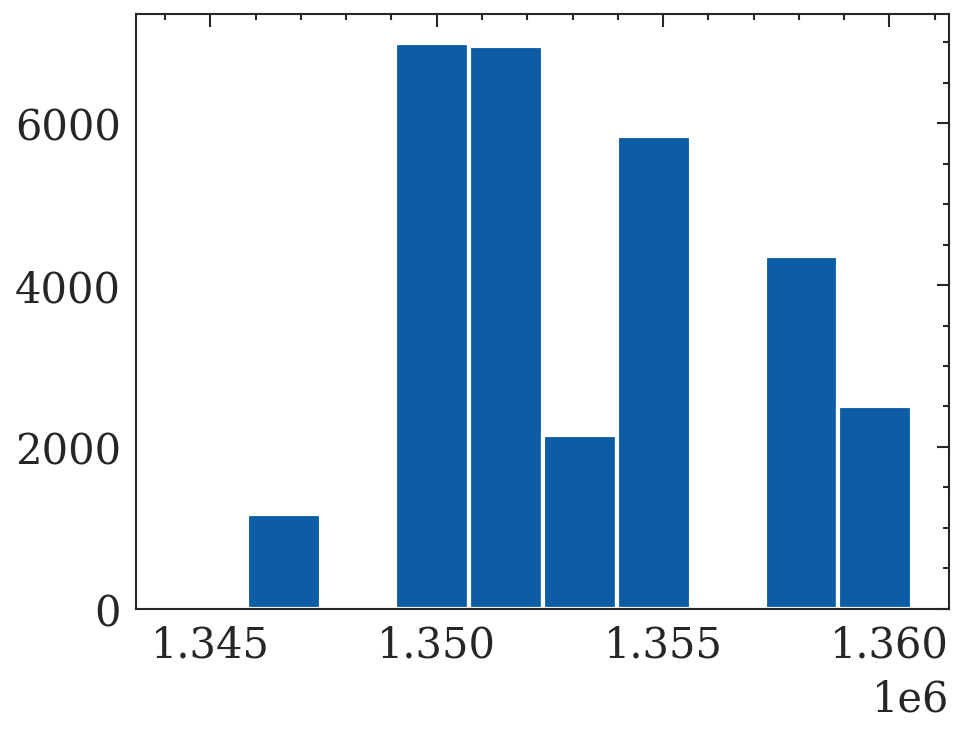

In [3]:
plt.hist(ov2_exp.sum(axis=1), bins=10);

In [4]:
ov2_exp.max()

A1BG        94.305000
A2M       1079.030029
A2ML1        0.000000
A4GALT      69.674004
AAAS        50.683998
             ...     
ZXDC        26.277000
ZYG11A       4.100000
ZYG11B      42.483002
ZYX        178.078995
ZZEF1       42.308998
Length: 16359, dtype: float32

In [5]:
ov2_h5ad = ov2_obj.get_h5ad()
ov2_h5ad.obs.head(2)

,Fibroblasts,B Cells,Endothelial Cells,Cancer Cells,T Cells,Macrophages,NK,ds
0,0.189949,0.066562,0.222084,0.200518,0.024337,0.120020,0.17653,
1,0.075982,0.147675,0.116676,0.238280,0.210690,0.030236,0.18046,


In [7]:
cell_prop = ov2_h5ad.obs.rename(columns={'CD8Tcells': 'CD8 T', 'Monocytes': 'Monocytes', 'Malignant': 'Cancer Cells', 
                                          'CD4Tcells': 'CD4 T', 'Fibroblast': 'Fibroblasts',
                                          'Epithelial': 'Epithelial Cells',
                                          'B_cell': 'B Cells', 
                                          'Macrophage': 'Macrophages',
                                          'Mast': 'Mast Cells',
                                          'T_cell': 'T Cells',
                                           'Dendritic': 'DC',
                                          'Endothelial': 'Endothelial Cells',
                                         }).copy()
cell_prop = cell_prop.iloc[:, range(0, 7)].copy()
cell_prop.head(2)

,Fibroblasts,B Cells,Endothelial Cells,Cancer Cells,T Cells,Macrophages,NK
0,0.189949,0.066562,0.222084,0.200518,0.024337,0.120020,0.17653
1,0.075982,0.147675,0.116676,0.238280,0.210690,0.030236,0.18046


In [8]:
cell_prop.columns.to_list()

['Fibroblasts',
 'B Cells',
 'Endothelial Cells',
 'Cancer Cells',
 'T Cells',
 'Macrophages',
 'NK']

In [9]:
cell_prop.shape

(30000, 7)

In [10]:
cell_prop.sum(axis=1)

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
29995    1.0
29996    1.0
29997    1.0
29998    1.0
29999    1.0
Length: 30000, dtype: float64

In [11]:
ov2_exp = non_log2log_cpm(ov2_exp, transpose=False)
ov2_exp.head(2)

,A1BG,A2M,A2ML1,A4GALT,AAAS,AACS,AADAC,AADACL2,AADAT,AAED1,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
0,5.345,7.748,0.0,3.806,4.070,3.210,1.426,0.199,1.196,4.971,...,2.517,3.805,5.167,2.479,1.756,1.346,0.171,3.819,6.264,2.944
1,5.014,7.228,0.0,3.189,3.812,3.205,1.826,0.000,0.885,4.508,...,2.069,3.920,5.324,1.419,2.006,2.298,0.144,3.654,5.756,3.344


In [12]:
np.all(ov2_exp.index == cell_prop.index)

True

In [13]:
new_h5ad = an.AnnData(X=ov2_exp, obs=cell_prop, dtype=np.float32)
# new_h5ad.write('../datasets/from_scaden/simu_bulk_Geistlinger2020_Ovarian_3CA_by_scaden_log2cpm1p.h5ad', compression=True)

### Using a limited number of cancer cells

In [2]:
merged_ds = an.read_h5ad('../datasets/single_cell/merged_12_sc_datasets_231003.h5ad')
merged_ds

AnnData object with n_obs × n_vars = 325474 × 17834
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample_id', 'batch', 'leiden1', 'dataset_id', 'original_cell_type', 'cell_type1', 'leiden', 'cell_type_first_round', 'cell_subtype', 'cell_type'
    var: 'gene_ids', 'n_cells', 'total_counts', 'n_counts'
    uns: 'cell_subtype_colors', 'cell_type1_colors', 'cell_type_colors', 'cell_type_first_round_colors', 'dataset_id_colors', 'dendrogram_leiden', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'original_cell_type_colors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
merged_ds_obs = merged_ds.obs.copy()
merged_ds_obs.head(2)

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample_id,batch,leiden1,dataset_id,original_cell_type,cell_type1,leiden,cell_type_first_round,cell_subtype,cell_type
AAACCTGAGCTGTCTA-1_HNSCC_1_TIL,2061,2044,9899.0,314.0,3.172038,hnscc_cillo_01_HNSCC_1_TIL,0,CD8 Tex,hnscc_cillo_01,,CD8 Tex,CD4 Treg (1),CD4 T,CD4 Treg,CD4 T
AAACCTGCAGCTGCTG-1_HNSCC_1_TIL,1261,1256,4692.0,118.0,2.514919,hnscc_cillo_01_HNSCC_1_TIL,0,CD4 T (3),hnscc_cillo_01,,CD4 T,Double-neg-like T (2),CD4 T,Double-neg-like T,Double-neg-like T


In [4]:
merged_ds_obs.groupby(['cell_type', 'dataset_id']).count()

n_genes  n_genes_by_counts  total_counts  \
cell_type   dataset_id                                                     
B Cells     gbm_abdelfattah_12      383                383           383   
            gbm_neftel_11            22                 22            22   
            hcc_sun_10              412                412           412   
            hnscc_cillo_01         7007               7007          7007   
            hnscc_puram_03          132                132           132   
...                                 ...                ...           ...   
Neutrophils pan_cancer_07             0                  0             0   
            pdac_peng_02             14                 14            14   
            pdac_steele_04         4775               4775          4775   
            prad_cheng_08            25                 25            25   
            prad_dong_09              0                  0             0   

                                total_counts_mt  pct_counts_mt  sample_id  \
cell_type   dataset_id                                                      
B Cells     gbm_abdelfattah_12              383            383        383   
            gbm_neftel_11                    22             22         22   
            hcc_sun_10                      412            412        412   
            hnscc_cillo_01                 7007           7007       7007   
            hnscc_puram_03                  132            132        132   
...                                         ...            ...        ...   
Neutrophils pan_cancer_07                     0              0          0   
            pdac_peng_02                     14             14         14   
            pdac_steele_04                 4775           4775       4775   
            prad_cheng_08                    25             25         25   
            prad_dong_09                      0              0          0   

                                batch  leiden1  original_cell_type  \
cell_type   dataset_id                                               
B Cells     gbm_abdelfattah_12    383      383                 383   
            gbm_neftel_11          22       22                  22   
            hcc_sun_10            412      412                 412   
            hnscc_cillo_01       7007     7007                7007   
            hnscc_puram_03        132      132                 132   
...                               ...      ...                 ...   
Neutrophils pan_cancer_07           0        0                   0   
            pdac_peng_02           14       14                  14   
            pdac_steele_04       4775     4775                4775   
            prad_cheng_08          25       25                  25   
            prad_dong_09            0        0                   0   

                                cell_type1  leiden  cell_type_first_round  \
cell_type   dataset_id                                                      
B Cells     gbm_abdelfattah_12         383     383                    383   
            gbm_neftel_11               22      22                     22   
            hcc_sun_10                 412     412                    412   
            hnscc_cillo_01            7007    7007                   7007   
            hnscc_puram_03             132     132                    132   
...                                    ...     ...                    ...   
Neutrophils pan_cancer_07                0       0                      0   
            pdac_peng_02                14      14                     14   
            pdac_steele_04            4775    4775                   4775   
            prad_cheng_08               25      25                     25   
            prad_dong_09                 0       0                      0   

                                cell_subtype  
cell_type   dataset_id                        
B Cells     gbm_abdelfattah_12    

In [5]:
merged_ds_obs_no_cancer = merged_ds_obs.loc[merged_ds_obs['cell_type'] != 'Cancer Cells', :].copy()
print(merged_ds_obs_no_cancer.shape)

(200410, 15)


In [6]:
merged_ds_obs_no_cancer['cell_type'].unique()

['CD4 T', 'Double-neg-like T', 'Monocytes', 'DC', 'CD8 T', ..., 'Mast Cells', 'Macrophages', 'Neutrophils', 'Endothelial Cells', 'Fibroblasts']
Length: 12
Categories (13, object): ['B Cells', 'CD4 T', 'CD8 T', 'Cancer Cells', ..., 'Mast Cells', 'Monocytes', 'NK', 'Neutrophils']

#### LUAD

In [27]:
luad_cancer_cell = merged_ds_obs.loc[(merged_ds_obs['cell_type'] == 'Cancer Cells') & (merged_ds_obs['dataset_id'] == 'luad_kim_05'), :].copy()
luad_cancer_cell.shape

(11340, 15)

In [28]:
merged_ds_obs_filtered = pd.concat([merged_ds_obs_no_cancer, luad_cancer_cell])
merged_ds_obs_filtered.shape

(211750, 15)

In [30]:
merged_ds_obs.loc[~merged_ds_obs.index.isin(merged_ds_obs_filtered.index), :].groupby(['dataset_id', 'cell_type']).count().to_csv('tpm.csv')

In [32]:
merged_ds_filtered = merged_ds[merged_ds.obs.index.isin(merged_ds_obs_filtered.index), :].copy()
merged_ds_filtered

AnnData object with n_obs × n_vars = 211750 × 17834
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample_id', 'batch', 'leiden1', 'dataset_id', 'original_cell_type', 'cell_type1', 'leiden', 'cell_type_first_round', 'cell_subtype', 'cell_type'
    var: 'gene_ids', 'n_cells', 'total_counts', 'n_counts'
    uns: 'cell_subtype_colors', 'cell_type1_colors', 'cell_type_colors', 'cell_type_first_round_colors', 'dataset_id_colors', 'dendrogram_leiden', 'leiden', 'log1p', 'neighbors', 'original_cell_type_colors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [33]:
merged_ds_filtered.write('../datasets/single_cell/merged_12_sc_ds_only_luad_cancer_cells.h5ad', compression=True)

In [37]:
merged_ds_obs_filtered.to_csv('merged_filtered.csv')

#### HNSCC

In [7]:
hnscc_cancer_cell = merged_ds_obs.loc[(merged_ds_obs['cell_type'] == 'Cancer Cells') & (merged_ds_obs['dataset_id'] == 'hnscc_puram_03'), :].copy()
hnscc_cancer_cell.shape

(2498, 15)

In [8]:
hnscc_cancer_cell.head(2)

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample_id,batch,leiden1,dataset_id,original_cell_type,cell_type1,leiden,cell_type_first_round,cell_subtype,cell_type
HN28_P6_D09_S141_comb,2198,2179,994976.6875,0.0,0.0,hnscc_puram_03_HN28,0,Fibroblasts (1),hnscc_puram_03,Fibroblasts,Fibroblasts,Epithelial Cells (2),Epithelial Cells,Epithelial Cells,Cancer Cells
HN28_P6_H07_S187_comb,2580,2554,994090.9375,0.0,0.0,hnscc_puram_03_HN28,0,Fibroblasts (1),hnscc_puram_03,Fibroblasts,Fibroblasts,Glioma Cells (3),Glioma Cells,Glioma Cells,Cancer Cells


In [9]:
merged_ds_obs_filtered = pd.concat([merged_ds_obs_no_cancer, hnscc_cancer_cell])
merged_ds_obs_filtered.shape

(202908, 15)

In [10]:
merged_ds_obs.loc[~merged_ds_obs.index.isin(merged_ds_obs_filtered.index), :].groupby(['dataset_id', 'cell_type']).count().to_csv('tpm.csv')

In [11]:
merged_ds_filtered = merged_ds[merged_ds.obs.index.isin(merged_ds_obs_filtered.index), :].copy()
merged_ds_filtered

AnnData object with n_obs × n_vars = 202908 × 17834
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample_id', 'batch', 'leiden1', 'dataset_id', 'original_cell_type', 'cell_type1', 'leiden', 'cell_type_first_round', 'cell_subtype', 'cell_type'
    var: 'gene_ids', 'n_cells', 'total_counts', 'n_counts'
    uns: 'cell_subtype_colors', 'cell_type1_colors', 'cell_type_colors', 'cell_type_first_round_colors', 'dataset_id_colors', 'dendrogram_leiden', 'leiden', 'log1p', 'neighbors', 'original_cell_type_colors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [12]:
merged_ds_filtered.write('../datasets/single_cell/merged_12_sc_ds_only_hnscc_cancer_cells.h5ad', compression=True)

#### PDAC

In [13]:
pdac_cancer_cell = merged_ds_obs.loc[(merged_ds_obs['cell_type'] == 'Cancer Cells') & (merged_ds_obs['dataset_id'] == 'pdac_peng_02'), :].copy()
pdac_cancer_cell.shape

(12636, 15)

In [14]:
pdac_cancer_cell.head(2)

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample_id,batch,leiden1,dataset_id,original_cell_type,cell_type1,leiden,cell_type_first_round,cell_subtype,cell_type
AACACGTCAATGACCT-1_T1,2041,2030,5375.0,319.0,5.934884,pdac_peng_02_T1,0,Epithelial Cells (2),pdac_peng_02,Ductal cell type 2,Cancer Cells,Epithelial Cells (6),Epithelial Cells,Epithelial Cells,Cancer Cells
AACCATGCACAACTGT-1_T1,1218,1212,2188.0,151.0,6.901280,pdac_peng_02_T1,0,Epithelial Cells (2),pdac_peng_02,Ductal cell type 2,Cancer Cells,Epithelial Cells (6),Epithelial Cells,Epithelial Cells,Cancer Cells


In [15]:
merged_ds_obs_filtered = pd.concat([merged_ds_obs_no_cancer, pdac_cancer_cell])
merged_ds_obs_filtered.shape

(213046, 15)

In [16]:
merged_ds_obs.loc[~merged_ds_obs.index.isin(merged_ds_obs_filtered.index), :].groupby(['dataset_id', 'cell_type']).count().to_csv('tpm.csv')

In [17]:
merged_ds_filtered = merged_ds[merged_ds.obs.index.isin(merged_ds_obs_filtered.index), :].copy()
merged_ds_filtered

AnnData object with n_obs × n_vars = 213046 × 17834
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample_id', 'batch', 'leiden1', 'dataset_id', 'original_cell_type', 'cell_type1', 'leiden', 'cell_type_first_round', 'cell_subtype', 'cell_type'
    var: 'gene_ids', 'n_cells', 'total_counts', 'n_counts'
    uns: 'cell_subtype_colors', 'cell_type1_colors', 'cell_type_colors', 'cell_type_first_round_colors', 'dataset_id_colors', 'dendrogram_leiden', 'leiden', 'log1p', 'neighbors', 'original_cell_type_colors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [18]:
merged_ds_filtered.write('../datasets/single_cell/merged_12_sc_ds_only_pdac_cancer_cells.h5ad', compression=True)

#### PRAD

In [19]:
prad_cancer_cell = merged_ds_obs.loc[(merged_ds_obs['cell_type'] == 'Cancer Cells') & (merged_ds_obs['dataset_id'] == 'prad_cheng_08'), :].copy()
prad_cancer_cell.shape

(18317, 15)

In [20]:
prad_cancer_cell.head(2)

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample_id,batch,leiden1,dataset_id,original_cell_type,cell_type1,leiden,cell_type_first_round,cell_subtype,cell_type
GAACCTAAGGTCATCT.1,2643,2640,999628.896586,0.0,0.0,prad_cheng_08_1,0,Epithelial Cells (1),prad_cheng_08,Cancer Cells,Cancer Cells,Epithelial Cells (4),Epithelial Cells,Epithelial Cells,Cancer Cells
TTGACTTTCGGACAAG.1,2543,2535,999153.349561,0.0,0.0,prad_cheng_08_1,0,Epithelial Cells (1),prad_cheng_08,Cancer Cells,Cancer Cells,Epithelial Cells (4),Epithelial Cells,Epithelial Cells,Cancer Cells


In [21]:
merged_ds_obs_filtered = pd.concat([merged_ds_obs_no_cancer, prad_cancer_cell])
merged_ds_obs_filtered.shape

(218727, 15)

In [22]:
merged_ds_obs.loc[~merged_ds_obs.index.isin(merged_ds_obs_filtered.index), :].groupby(['dataset_id', 'cell_type']).count().to_csv('tpm.csv')

In [23]:
merged_ds_filtered = merged_ds[merged_ds.obs.index.isin(merged_ds_obs_filtered.index), :].copy()
merged_ds_filtered

AnnData object with n_obs × n_vars = 218727 × 17834
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample_id', 'batch', 'leiden1', 'dataset_id', 'original_cell_type', 'cell_type1', 'leiden', 'cell_type_first_round', 'cell_subtype', 'cell_type'
    var: 'gene_ids', 'n_cells', 'total_counts', 'n_counts'
    uns: 'cell_subtype_colors', 'cell_type1_colors', 'cell_type_colors', 'cell_type_first_round_colors', 'dataset_id_colors', 'dendrogram_leiden', 'leiden', 'log1p', 'neighbors', 'original_cell_type_colors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [24]:
merged_ds_filtered.write('../datasets/single_cell/merged_12_sc_ds_only_prad_cancer_cells.h5ad', compression=True)

#### HCC

In [26]:
hcc_cancer_cell = merged_ds_obs.loc[(merged_ds_obs['cell_type'] == 'Cancer Cells') & (merged_ds_obs['dataset_id'] == 'hcc_sun_10'), :].copy()
hcc_cancer_cell.shape

(2018, 15)

In [27]:
hcc_cancer_cell.head(2)

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample_id,batch,leiden1,dataset_id,original_cell_type,cell_type1,leiden,cell_type_first_round,cell_subtype,cell_type
P02_T_0322,7951,7928,999004.071494,26620.083231,2.664662,hcc_sun_10_P02,0,Epithelial Cells (2),hcc_sun_10,Cancer Cells,Cancer Cells,Glioma Cells (2),Glioma Cells,Glioma Cells,Cancer Cells
P02_T_0325,5851,5840,999838.755963,62147.633660,6.215766,hcc_sun_10_P02,0,Epithelial Cells (1),hcc_sun_10,Cancer Cells,Cancer Cells,Epithelial Cells (5),Epithelial Cells,Epithelial Cells,Cancer Cells


In [28]:
merged_ds_obs_filtered = pd.concat([merged_ds_obs_no_cancer, hcc_cancer_cell])
merged_ds_obs_filtered.shape

(202428, 15)

In [29]:
merged_ds_obs.loc[~merged_ds_obs.index.isin(merged_ds_obs_filtered.index), :].groupby(['dataset_id', 'cell_type']).count().to_csv('tpm.csv')

In [30]:
merged_ds_filtered = merged_ds[merged_ds.obs.index.isin(merged_ds_obs_filtered.index), :].copy()
merged_ds_filtered

AnnData object with n_obs × n_vars = 202428 × 17834
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample_id', 'batch', 'leiden1', 'dataset_id', 'original_cell_type', 'cell_type1', 'leiden', 'cell_type_first_round', 'cell_subtype', 'cell_type'
    var: 'gene_ids', 'n_cells', 'total_counts', 'n_counts'
    uns: 'cell_subtype_colors', 'cell_type1_colors', 'cell_type_colors', 'cell_type_first_round_colors', 'dataset_id_colors', 'dendrogram_leiden', 'leiden', 'log1p', 'neighbors', 'original_cell_type_colors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [31]:
merged_ds_filtered.write('../datasets/single_cell/merged_12_sc_ds_only_hcc_cancer_cells.h5ad', compression=True)

#### GBM

In [32]:
gbm_cancer_cell = merged_ds_obs.loc[(merged_ds_obs['cell_type'] == 'Cancer Cells') & (merged_ds_obs['dataset_id'] == 'gbm_abdelfattah_12'), :].copy()
gbm_cancer_cell.shape

(17891, 15)

In [33]:
gbm_cancer_cell.head(2)

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample_id,batch,leiden1,dataset_id,original_cell_type,cell_type1,leiden,cell_type_first_round,cell_subtype,cell_type
AAACCTGAGACATAAC-1_GSM5518600_ndGBM-01-A,2297,2293,7655.0,138.0,1.802743,gbm_abdelfattah_12_GSM5518600_ndGBM-01-A,1,Fibroblasts (2),gbm_abdelfattah_12,,Fibroblasts,Glioma Cells (3),Glioma Cells,Glioma Cells,Cancer Cells
AAACCTGAGGCACATG-1_GSM5518600_ndGBM-01-A,888,888,1495.0,3.0,0.200669,gbm_abdelfattah_12_GSM5518600_ndGBM-01-A,1,Fibroblasts (1),gbm_abdelfattah_12,,Fibroblasts,Glioma Cells (3),Glioma Cells,Glioma Cells,Cancer Cells


In [34]:
merged_ds_obs_filtered = pd.concat([merged_ds_obs_no_cancer, gbm_cancer_cell])
merged_ds_obs_filtered.shape

(218301, 15)

In [35]:
merged_ds_obs.loc[~merged_ds_obs.index.isin(merged_ds_obs_filtered.index), :].groupby(['dataset_id', 'cell_type']).count().to_csv('tpm.csv')

In [36]:
merged_ds_filtered = merged_ds[merged_ds.obs.index.isin(merged_ds_obs_filtered.index), :].copy()
merged_ds_filtered

AnnData object with n_obs × n_vars = 218301 × 17834
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample_id', 'batch', 'leiden1', 'dataset_id', 'original_cell_type', 'cell_type1', 'leiden', 'cell_type_first_round', 'cell_subtype', 'cell_type'
    var: 'gene_ids', 'n_cells', 'total_counts', 'n_counts'
    uns: 'cell_subtype_colors', 'cell_type1_colors', 'cell_type_colors', 'cell_type_first_round_colors', 'dataset_id_colors', 'dendrogram_leiden', 'leiden', 'log1p', 'neighbors', 'original_cell_type_colors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [37]:
merged_ds_filtered.write('../datasets/single_cell/merged_12_sc_ds_only_gbm_cancer_cells.h5ad', compression=True)

#### Pan-cancer

In [38]:
pan_cancer_cell = merged_ds_obs.loc[(merged_ds_obs['cell_type'] == 'Cancer Cells') & (merged_ds_obs['dataset_id'] == 'pan_cancer_07'), :].copy()
pan_cancer_cell.shape

(30658, 15)

In [39]:
pan_cancer_cell.head(2)

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample_id,batch,leiden1,dataset_id,original_cell_type,cell_type1,leiden,cell_type_first_round,cell_subtype,cell_type
AAACCTGAGACATAAC-1-18,4318,4318,999999.9375,37968.406250,3.796841,pan_cancer_07,0,54,pan_cancer_07,,Cancer Cells,Epithelial Cells (9),Epithelial Cells,Epithelial Cells,Cancer Cells
AACGTTGTCACCCGAG-1-18,5200,5200,1000000.0000,34923.253906,3.492326,pan_cancer_07,0,54,pan_cancer_07,,Cancer Cells,Epithelial Cells (8),Epithelial Cells,Epithelial Cells,Cancer Cells


In [40]:
merged_ds_obs_filtered = pd.concat([merged_ds_obs_no_cancer, pan_cancer_cell])
merged_ds_obs_filtered.shape

(231068, 15)

In [41]:
merged_ds_obs.loc[~merged_ds_obs.index.isin(merged_ds_obs_filtered.index), :].groupby(['dataset_id', 'cell_type']).count().to_csv('tpm.csv')

In [42]:
merged_ds_filtered = merged_ds[merged_ds.obs.index.isin(merged_ds_obs_filtered.index), :].copy()
merged_ds_filtered

AnnData object with n_obs × n_vars = 231068 × 17834
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample_id', 'batch', 'leiden1', 'dataset_id', 'original_cell_type', 'cell_type1', 'leiden', 'cell_type_first_round', 'cell_subtype', 'cell_type'
    var: 'gene_ids', 'n_cells', 'total_counts', 'n_counts'
    uns: 'cell_subtype_colors', 'cell_type1_colors', 'cell_type_colors', 'cell_type_first_round_colors', 'dataset_id_colors', 'dendrogram_leiden', 'leiden', 'log1p', 'neighbors', 'original_cell_type_colors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [43]:
merged_ds_filtered.write('../datasets/single_cell/merged_12_sc_ds_only_pan_cancer_cells.h5ad', compression=True)